In [11]:
#Import necessary Libraries

import numpy as np                      
import pandas as pd                     
import matplotlib.pyplot as plt         
import seaborn as sns                   
from sklearn.datasets import load_breast_cancer   
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler      
from sklearn.pipeline import make_pipeline            
from sklearn.linear_model import LogisticRegression    
from sklearn.ensemble import RandomForestClassifier    
from sklearn.metrics import (                          
    accuracy_score, confusion_matrix,
    classification_report, roc_curve, auc)


In [12]:
#LOAD Data and convert to pandas Dataframe
cancer = load_breast_cancer()                          # sklearn's B‑C data
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)  # Features
y = pd.Series(cancer.target, name="target")            # 0 = malignant, 1 = benign

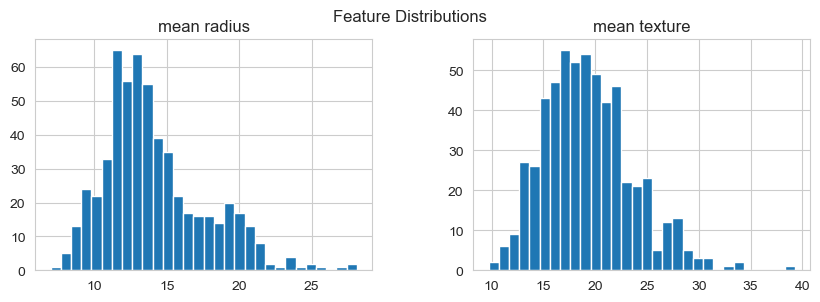

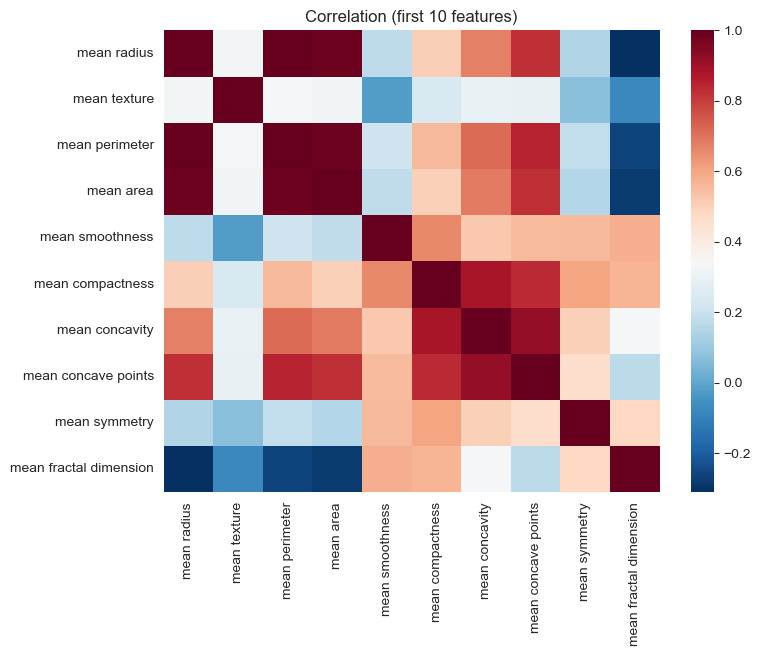

In [13]:
#EDA
sns.set_style("whitegrid")                             
X.describe().T.head()                                  

# Histogram of two influential features
X[['mean radius', 'mean texture']].hist(bins=30, figsize=(10,3))
plt.suptitle("Feature Distributions"); plt.show()

# Correlation heat‑map (only the first 10 features for readability)
plt.figure(figsize=(8,6))
sns.heatmap(X.iloc[:, :10].corr(), annot=False, cmap="RdBu_r")
plt.title("Correlation (first 10 features)"); plt.show()

In [14]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
#Model 1 Logistic Regression(Linear, Baseline)
logreg_pipe = make_pipeline(StandardScaler(),                    
    LogisticRegression(max_iter=1000))
logreg_pipe.fit(X_train, y_train)        

log_pred = logreg_pipe.predict(X_test)   
log_acc  = accuracy_score(y_test, log_pred)     
print(f"Logistic‑Regression accuracy: {log_acc:.3f}")

Logistic‑Regression accuracy: 0.982


In [16]:
#Model 2 Random Forest(Non-linear, often better)
rf = RandomForestClassifier(n_estimators=300,        
    max_depth=None,          
    random_state=42)
rf.fit(X_train, y_train)               # Build the forest

rf_pred = rf.predict(X_test)           # Predictions
rf_acc  = accuracy_score(y_test, rf_pred)
print(f"Random‑Forest accuracy: {rf_acc:.3f}")

Random‑Forest accuracy: 0.947


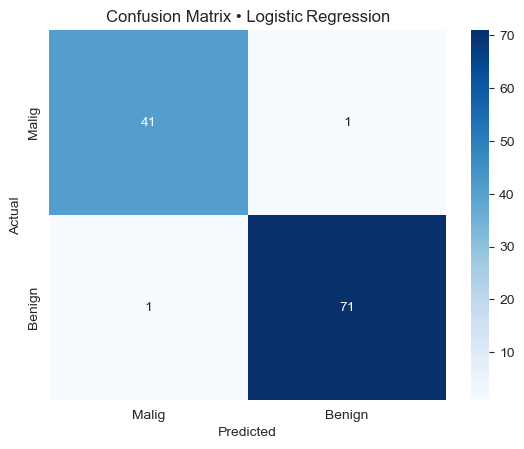

              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [17]:
#Confusion Matrix for the better model:
best_pred = rf_pred if rf_acc >= log_acc else log_pred
best_name = "Random Forest" if rf_acc >= log_acc else "Logistic Regression"

cm = confusion_matrix(y_test, best_pred)     
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Malig","Benign"], yticklabels=["Malig","Benign"])
plt.title(f"Confusion Matrix • {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

print(classification_report(y_test, best_pred, target_names=["Malignant","Benign"]))

C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


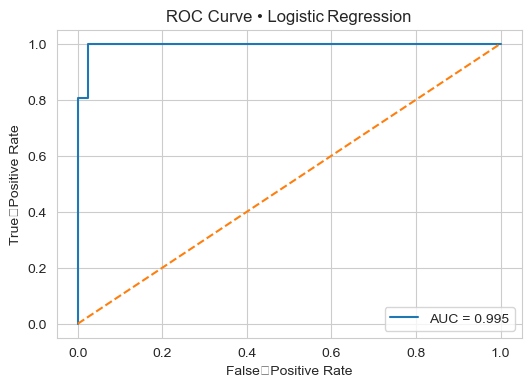

In [18]:
#ROC Curve (True-pos vs False-pos)
probs   = (rf if rf_acc>=log_acc else logreg_pipe).predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)     # x = FPR, y = TPR
roc_auc = auc(fpr, tpr)                    # Area under curve

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False‑Positive Rate"); plt.ylabel("True‑Positive Rate")
plt.title(f"ROC Curve • {best_name}"); plt.legend(); plt.show()

Random‑Forest accuracy : 0.947
Logistic‑Reg accuracy  : 0.982


C:\Users\admin\AppData\Local\Temp\ipykernel_13464\3058870487.py:22: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


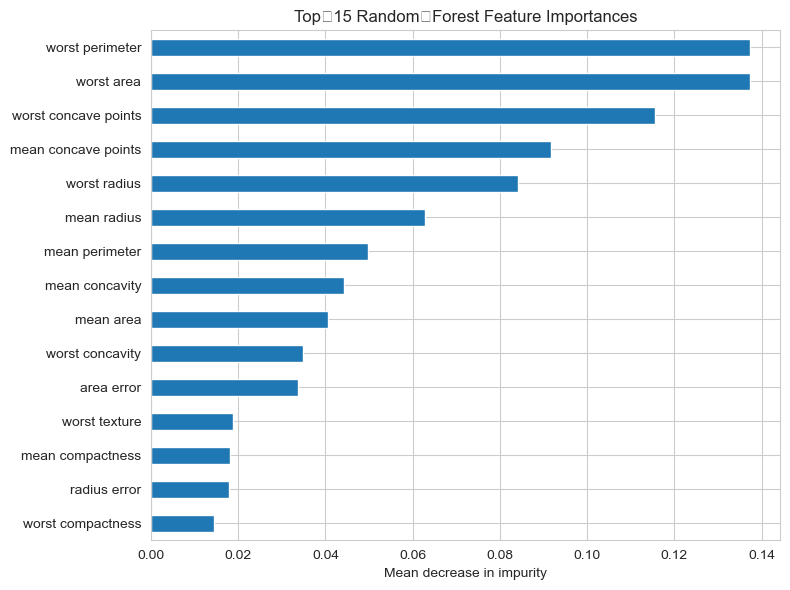

In [20]:
#Feature Importance (Random Forest)
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

print(f"Random‑Forest accuracy : {rf_acc:.3f}")
print(f"Logistic‑Reg accuracy  : {log_acc:.3f}")

imp = (pd.Series(rf.feature_importances_, index=X.columns)
         .sort_values(ascending=False)
         .head(15))

#  Draw the bar‑chart in a fresh figure
fig, ax = plt.subplots(figsize=(8, 6))        
imp.plot(kind="barh", ax=ax, legend=False)
ax.invert_yaxis()                             
ax.set_title("Top‑15 Random‑Forest Feature Importances")
ax.set_xlabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_13464\884880312.py:18: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from current font.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_13464\884880312.py:18: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


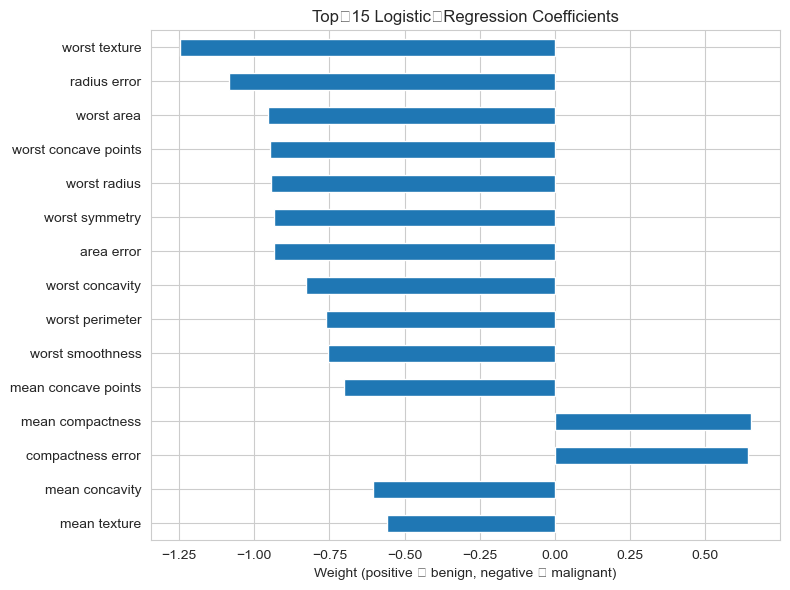

In [21]:
#Feature importance for logistic regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pull the fitted coefficients (one per feature)
coef = pd.Series(
    logreg_pipe.named_steps['logisticregression'].coef_[0], 
    index=X.columns
).sort_values(key=np.abs, ascending=False)   # sort by |weight|

# Plot the 15 strongest (signed) effects
plt.figure(figsize=(8,6))
coef.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top‑15 Logistic‑Regression Coefficients')
plt.xlabel('Weight (positive ⇒ benign, negative ⇒ malignant)')
plt.tight_layout()
plt.show()